## Convocatoria 1 - Proyecto 1

- Nombre: Julio Emanuel Suriano Bryk
- Fecha de Entrega: 26/07/24

<a href="https://colab.research.google.com/github/EmaSuriano/python-demos/blob/main/submits/supervised-learning/Actividad_C1_P1_Julio_Emanuel_Suriano_Bryk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [93]:
# Import of libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import binary_fill_holes

# skimage functions
from skimage import io, measure, morphology
from skimage.filters import gaussian, threshold_otsu
from skimage.color import rgb2gray
from skimage.segmentation import flood_fill

In [94]:
# default values
FIG_SIZE = (4, 4)
CONTOUR_COLOR = "green"
CONTOUR_WIDTH = 2


# helpers functions
def show_img(image: np.ndarray, title: str, cmap="gray", contours=[]) -> None:
    """display image usint matplotlib

    Args:
        image (np.ndarray): image data
        title (str): title of the plot
        cmap (str, optional): cmap value for imshow. Defaults to "gray".
        contours (list, optional): list of countors to render along the graph. Defaults to [].
    """
    plt.figure(figsize=FIG_SIZE)
    plt.imshow(image, cmap=cmap)

    # Plot countours
    for contour in contours:
        plt.plot(
            contour[:, 1], contour[:, 0], color=CONTOUR_COLOR, linewidth=CONTOUR_WIDTH
        )

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def compare_imgs(images: list[tuple[np.ndarray, str]], cmap="gray") -> None:
    """display several images using subplots of matplotlib

    Args:
        images (list[tuple[np.ndarray, str]]): list of images with title
        cmap (str, optional): cmap value for imshow. Defaults to "gray".
    """
    figsize = (FIG_SIZE[0] * len(images), FIG_SIZE[1])
    _, ax = plt.subplots(1, len(images), figsize=figsize)

    for i, (img, title) in enumerate(images):
        ax[i].imshow(img, cmap=cmap)
        ax[i].set_title(title)
        ax[i].axis("off")

    plt.tight_layout()
    plt.show()

#### 0) Cargar una de las imágenes histológicas

```python
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
# Visualizar la imagen
```


Rango de valores: [0.11372549019607843, 1.0]


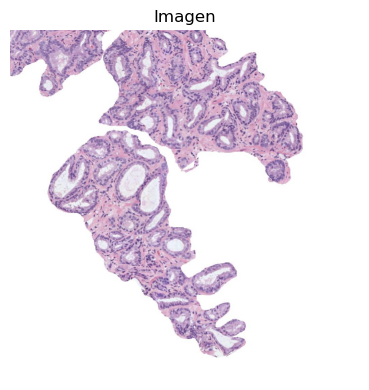

In [95]:
# Load initial image
img = io.imread("./histo_1.jpg")

# Normalize image
img_normalize = img / 255
print("Rango de valores:", [np.min(img_normalize), np.max(img_normalize)])

show_img(img_normalize, "Imagen")

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

```python
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
# Visualizar la imagen del canal magenta
```


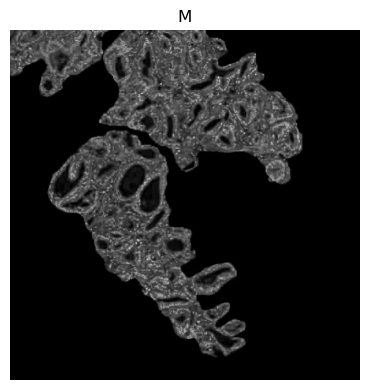

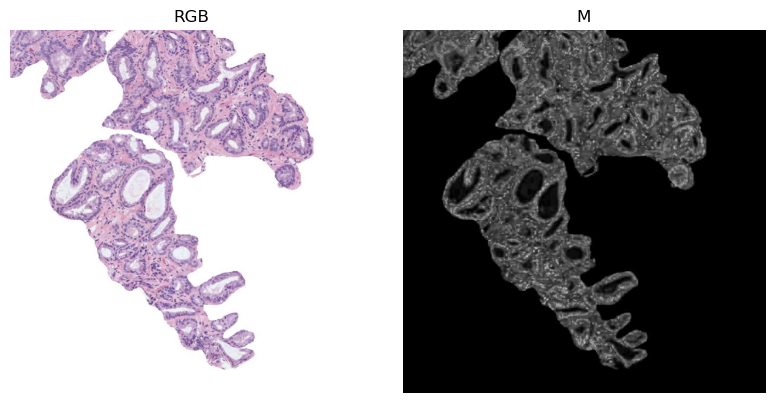

In [96]:
# Extract RGB
R, G, B = img_normalize[:, :, 0], img_normalize[:, :, 1], img_normalize[:, :, 2]

with np.errstate(divide="ignore", invalid="ignore"):
    # RGB to CMY
    C, M, Y = 1 - R, 1 - G, 1 - B

    # CMY to CMYK
    K = np.minimum(C, np.minimum(M, Y))

    C = (C - K) / (1 - K)
    M = (M - K) / (1 - K)
    Y = (Y - K) / (1 - K)

compare_imgs([[img, "RGB"], [M, "M"]])

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

```python
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante

```


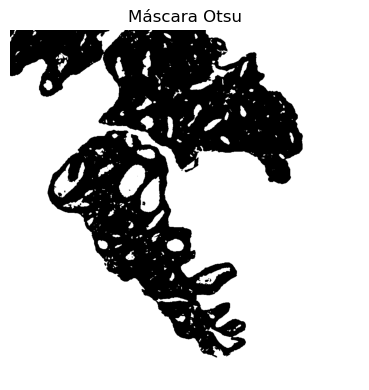

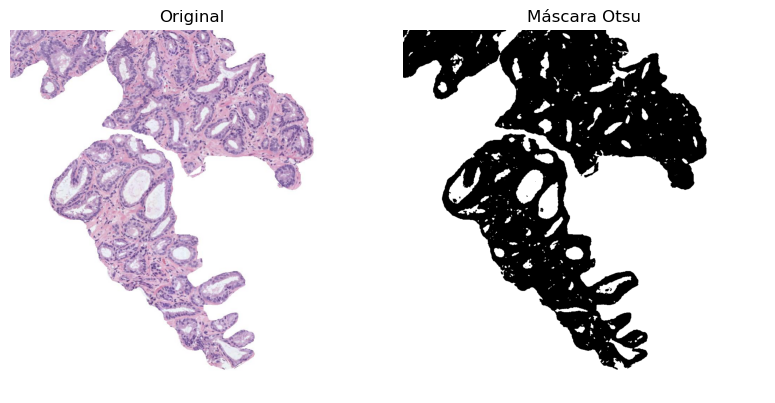

In [97]:
# we have to convert to gray scale to use Otsu
img_gray = rgb2gray(img)

# apply gaussian blur
img_blurred = gaussian(img_gray, sigma=1, mode="reflect", truncate=2.5)

# apply otsu threshold
otsu_threshold = threshold_otsu(img_blurred)

# obtain mask from otsu
otsu_binary_mask = img_blurred > otsu_threshold

compare_imgs([[img, "Original"], [otsu_binary_mask, "Máscara Otsu"]])

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

```python
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante

```


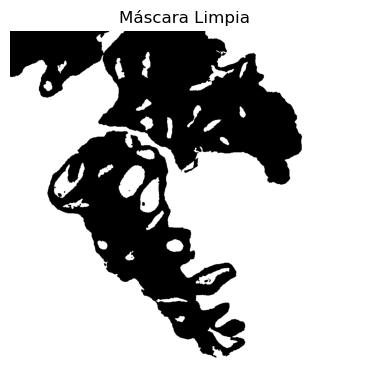

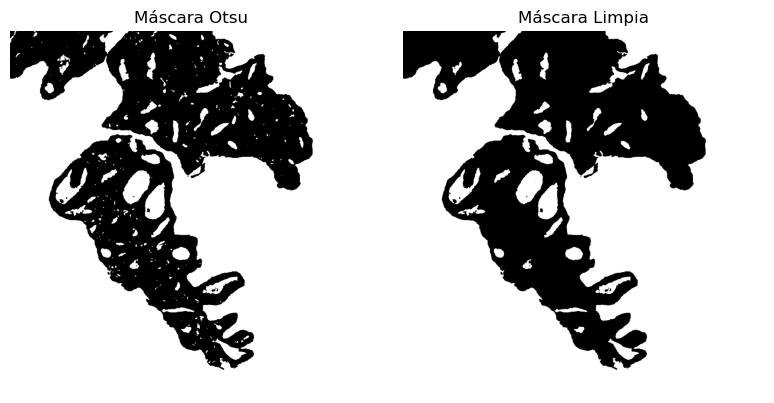

In [98]:
# remove small objects to get clean mask
cleaned_mask = morphology.remove_small_objects(otsu_binary_mask, min_size=300)

compare_imgs([[otsu_binary_mask, "Máscara Otsu"], [cleaned_mask, "Máscara Limpia"]])

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

```python
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante.
```


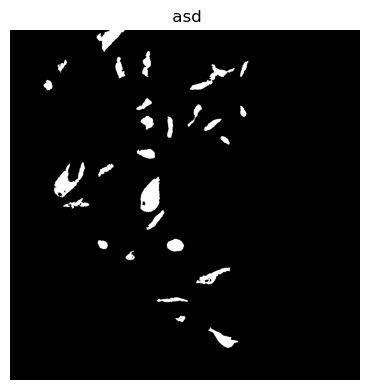

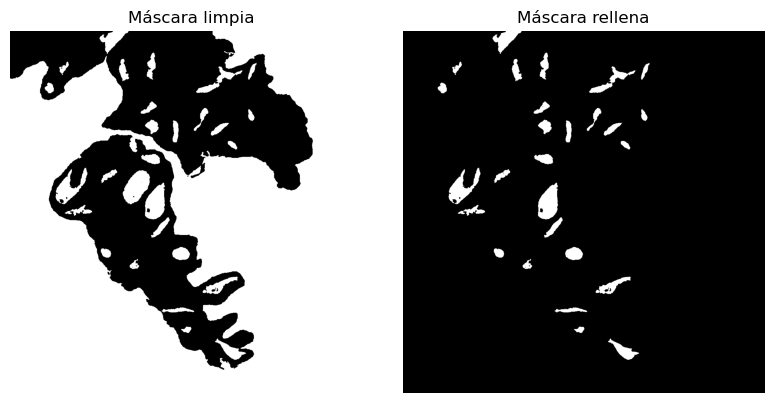

In [99]:
def find_seeds(mask: np.ndarray, num_seeds=2) -> list[tuple[int, int]]:
    """find background seeds of a mask

    Args:
        mask (np.ndarray): image mask which should be already cleaned
        num_seeds (int, optional): amount of seeds to find and return. Defaults to 2.

    Returns:
        list[tuple[int, int]]: list of seeds from mask
    """
    # Get regions from mask
    regions = measure.regionprops(measure.label(mask))

    # Sort regions by area and select amount of seeds
    regions = sorted(regions, key=lambda r: r.area, reverse=True)[:num_seeds]

    # Get the centroid from each region and parse to int
    seeds = [tuple(map(int, r.centroid)) for r in regions]

    return seeds


# obtain seeds from mask
seeds = find_seeds(cleaned_mask, 2)

# apply flood_fill to all seeds
filled_mask = cleaned_mask.astype("int")
for seed in seeds:
    filled_mask = flood_fill(filled_mask, seed, 0)

compare_imgs([[cleaned_mask, "Máscara limpia"], [filled_mask, "Máscara rellena"]])

#### 5) Rellenar los objetos de los lúmenes

```python
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante
```


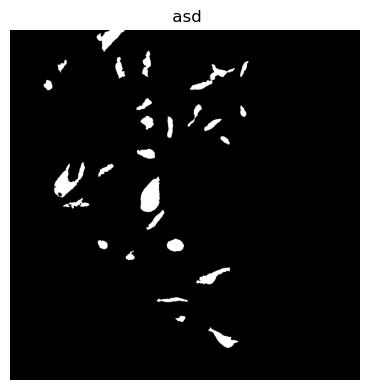

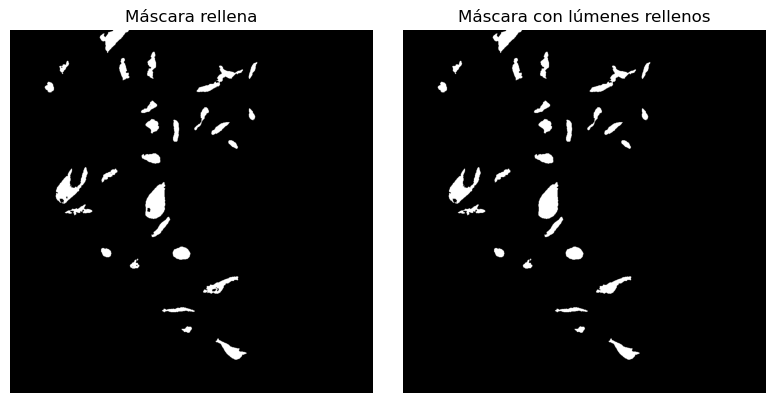

In [100]:
# apply binary_fill_holes function
filled_holes = binary_fill_holes(filled_mask)

compare_imgs(
    [
        [filled_mask, "Máscara rellena"],
        [filled_holes, "Máscara con lúmenes rellenos"],
    ]
)

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

```python
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles.
# Visualizar la imagen superpuesta
```


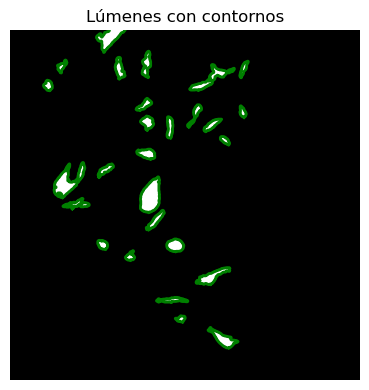

In [101]:
# get contours using measure func --> https://scikit-image.org/docs/stable/auto_examples/edges/plot_contours.html#sphx-glr-auto-examples-edges-plot-contours-py
contours = measure.find_contours(filled_holes, level=0.5)

show_img(filled_holes, "Lúmenes con contornos", contours=contours)

#### 7) Identificar y cropear el lumen más grande

```python
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.
```


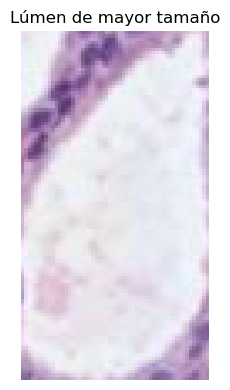

In [102]:
# get regions from mask
regions = measure.regionprops(measure.label(filled_holes))

# obtain biggest region
biggest_lumen = max(regions, key=lambda r: r.area)

# obtain bbox points coordinates
x0, y0, x1, y1 = biggest_lumen.bbox

# use coordinates to crop original image
img_lumen = img[x0:x1, y0:y1]

show_img(img_lumen, "Lúmen de mayor tamaño")

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado

```python
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad
```


In [103]:
features = {
    "Área": biggest_lumen.area,
    "Área de la Bounding Box": (x1 - x0) * (y1 - y0),
    "Área Convexa": biggest_lumen.convex_area,
    "Excentricidad": biggest_lumen.eccentricity,
    "Diámetro Equivalente": biggest_lumen.equivalent_diameter,
    "Extensión": biggest_lumen.extent,
    "Diámetro Feret": biggest_lumen.feret_diameter_max,
    "Longitud del Eje Mayor": biggest_lumen.major_axis_length,
    "Longitud del Eje Menor": biggest_lumen.minor_axis_length,
    "Orientación": biggest_lumen.orientation,
    "Perímetro": biggest_lumen.perimeter,
    "Solidez": biggest_lumen.solidity,
    # Formula to calculate compactness --> https://isovists.org/user-guide/4-2-3-compactness/
    "Compacidad": 4 * np.pi * biggest_lumen.area / (biggest_lumen.perimeter**2),
}

# Convert to DataFrame and round up values
df_features = pd.DataFrame([features]).round(4)

df_features

{'Área': 4201.0, 'Área de la Bounding Box': 5824, 'Área Convexa': 4368.0, 'Excentricidad': 0.8558946644529484, 'Diámetro Equivalente': 73.1360330304592, 'Extensión': 0.7213255494505495, 'Diámetro Feret': 110.30865786510141, 'Longitud del Eje Mayor': 103.28347194136195, 'Longitud del Eje Menor': 53.41306757211333, 'Orientación': -0.28688781380205053, 'Perímetro': 281.5218613006979, 'Solidez': 0.9617673992673993, 'Compacidad': 0.6660982538191065}


,Área,Área de la Bounding Box,Área Convexa,Excentricidad,Diámetro Equivalente,Extensión,Diámetro Feret,Longitud del Eje Mayor,Longitud del Eje Menor,Orientación,Perímetro,Solidez,Compacidad
0,4201.0,5824,4368.0,0.8559,73.136,0.7213,110.3087,103.2835,53.4131,-0.2869,281.5219,0.9618,0.6661
